# Exploratory data analysis using Kallisto data
transcripts per million output was obtained from cluster

# Table of Contents
* <a href='#Importing-necessary-things'>Importing necessary things</a>
Also placing functions that we will use later
* <a href='#Looking at a single file'>Looking at a single file</a>
In this section we plot a histogram of the log values of a typical file.  
* <a href='#Using all files'>Using all files</a>
We look at all the files. We also plot descriptions of the log values of two kind of weird files (Zi238_C4 and FR188_T3).  These weird files had also shown up as outliers in a PCA plot (not shown).  Zi238 was a very clear outlier, then FR188_T3.  We just removed both of them
* <a href='#Preliminary PCA non logged'>Preliminary PCA non logged</a> We see here that T and C cluster together, but not much else.  If we were to look at testes only data or carcass only data with this non-logged data, we don't see any clustering by line or country, even on 2nd and 3rd components (not plotted)
* <a href='#Preliminary PCA logged'>Preliminary PCA logged</a> Same results as above when cutoffs of 0, .1 and .01 TPM applied.
* <a href='#Carcass only data'>Carcass only data</a> Here we look at carcass only data on logged data.  Can't see any clustering by country or line, even when cutoffs of .1 and .01 TPM applied.
* <a href='#Testes only data'>Testes only data</a> Here we look at carcass only data on logged data. Can't see any clustering by country or line, even when cutoffs of .1 and .01 TPM applied.


<a id='Importing-necessary-things'></a>
##Importing necessary things

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image
from sklearn.decomposition import PCA

In [2]:
def applyLabels(LoadedData, pca, country=True, TorC=True, lineLabels=True):
    dictOfLabels={}
    if TorC:
        TorClabels=[a.split('_')[1][0] for a in LoadedData.columns]
        dictOfLabels["TorC"]=TorClabels
    if lineLabels:
        lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in LoadedData.columns]
        dictOfLabels["lines"]=lineLabels
    if country:
        countryLabels=[a[:2] for a in LoadedData.columns]
        dictOfLabels["country"]=countryLabels
    dfPCA=pd.DataFrame(dictOfLabels)
    for i in range(pca.explained_variance_ratio_.shape[0]):
        dfPCA["pc%i" % (i+1)] = X[:,i]
    return dfPCA


def plot_PCA(labelName, df, firstComponent="pc1", secondComponent="pc2"):
    plt.figure()
    colors=["red","blue","yellow", "green"]
    for label, color in zip(df[labelName].unique(), colors):
        mask = df[labelName]==label
        plt.scatter(df[mask][firstComponent], df[mask][secondComponent], c=color, label=label)
    plt.legend()
    plt.title(labelName +" PCA plot")
    plt.xlabel(firstComponent)
    plt.ylabel(secondComponent)
    plt.show()

<a id='Looking at a single file'></a>
###Looking at a single file

In [3]:
Fr188_C1=pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/Fr188_C1_TTAGGC/abundance.tsv",sep="\t")


In [4]:
Fr188_C1.head()

,target_id,length,eff_length,est_counts,tpm
0,FBtr0071764,5173,4974,33.8472,0.504464
1,FBtr0100521,4665,4466,179.1580,2.973920
2,FBtr0071763,4847,4648,142.0220,2.265180
3,FBtr0342981,3897,3698,36.9729,0.741191
4,FBtr0083388,3935,3736,103.4280,2.052320


Checking that tpm sum up to 1000000

In [5]:
sum(Fr188_C1.tpm) , len(Fr188_C1)

(999999.92981562519, 30446)

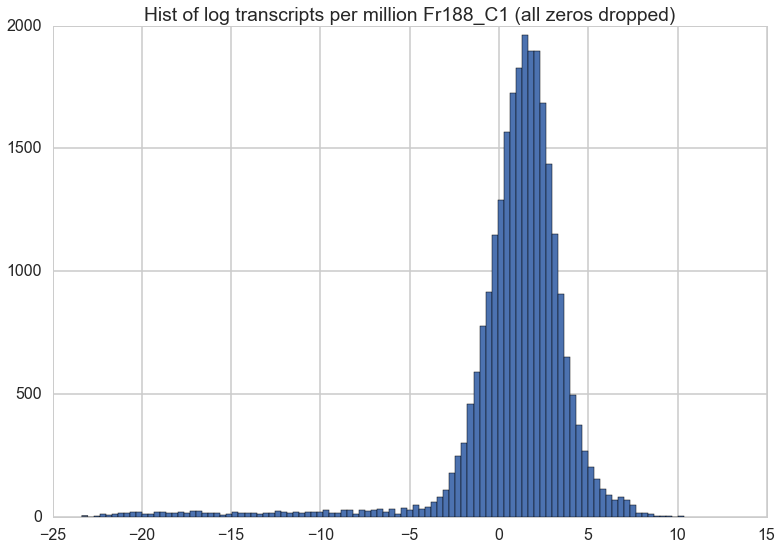

In [6]:
plt.hist(np.log(Fr188_C1[Fr188_C1.tpm>0].tpm), bins=100)
plt.title("Hist of log transcripts per million Fr188_C1 (all zeros dropped)")
plt.show()

Now plotting the weird outliers that showed up when we naively tried PCA.  We can tell that our data for Zi238_C4 is wrong -- too many zeros!  It also looks like Fr188_T3 might have a little bit of an excess of zeros, though it's not as terrible as Zi238.

<a id='Using all files'></a>
#Looking at the output of all Kallisto files

In [7]:
#Create a dataframe with tpm data from all files
import glob
import string
files_dict={}
for fl in glob.glob("../KallistoFiles/*"):
    a= string.join(fl.split('/')[2].split('_')[:2], sep="_")
    if a:
        files_dict[a]=pd.read_csv(fl+"/abundance.tsv", sep="\t").tpm

LoadedData=pd.DataFrame(files_dict)

Fr188_C1     4561
Fr188_C2     5140
Fr188_C3     7146
Fr188_T3     9096
Fr188_T5     6073
Fr188_T6     7035
Fr89_C1      4979
Fr89_C2      6070
Fr89_C4      5245
Fr89_T3      5680
Fr89_T4      6639
Fr89_T5      6684
Zi238_C1     5082
Zi238_C2     7386
Zi238_C3     5670
Zi238_C4    30376
Zi238_T2     7089
Zi238_T3     7832
Zi238_T4     6323
Zi257_C1     7584
Zi257_C2     8281
Zi257_C3     6892
Zi257_T1     6934
Zi257_T2     6011
Zi257_T3     6604
Zi257_T4     7437
dtype: int64


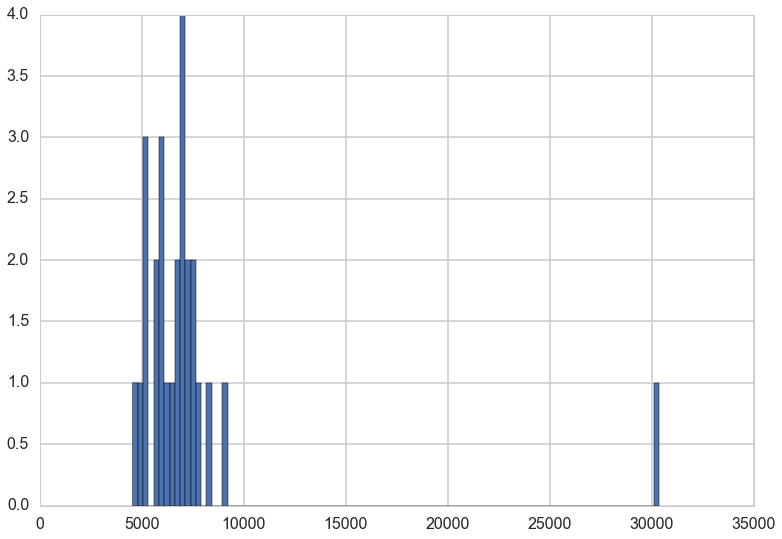

In [8]:
#Seeing how many zeros there are for each column
print LoadedData.apply(func=lambda x: len(x[x==0]), axis=0)
LoadedData.apply(func=lambda x: len(x[x==0]), axis=0).hist(bins=100)

We can see from the above plots that Zi238 is a clear outlier.  Fr188_T3 is sortof outlier-ish.  We now look at these files in more detail.

Zi238_C4              length    eff_length    est_counts            tpm
count  30446.000000  30446.000000  30446.000000   30446.000000
mean    2880.506799   2681.526523      0.001905      32.845053
std     2923.355696   2923.337487      0.043602    1223.168153
min      108.000000      2.875620      0.000000       0.000000
25%     1249.000000   1050.000000      0.000000       0.000000
50%     2153.000000   1954.000000      0.000000       0.000000
75%     3634.000000   3435.000000      0.000000       0.000000
max    71382.000000  71183.000000      2.000000  164917.000000

Fr188_T3              length    eff_length    est_counts            tpm
count  30446.000000  30446.000000  30446.000000   30446.000000
mean    2880.506799   2681.526523    113.720985      32.845050
std     2923.355696   2923.337487    544.824878     965.640450
min      108.000000      2.875620      0.000000       0.000000
25%     1249.000000   1050.000000      0.000000       0.000000
50%     2153.000000   1954.000000   

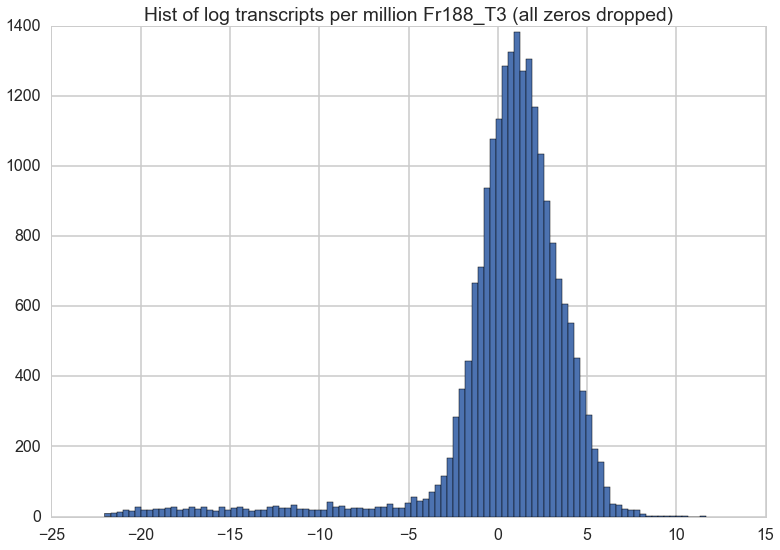

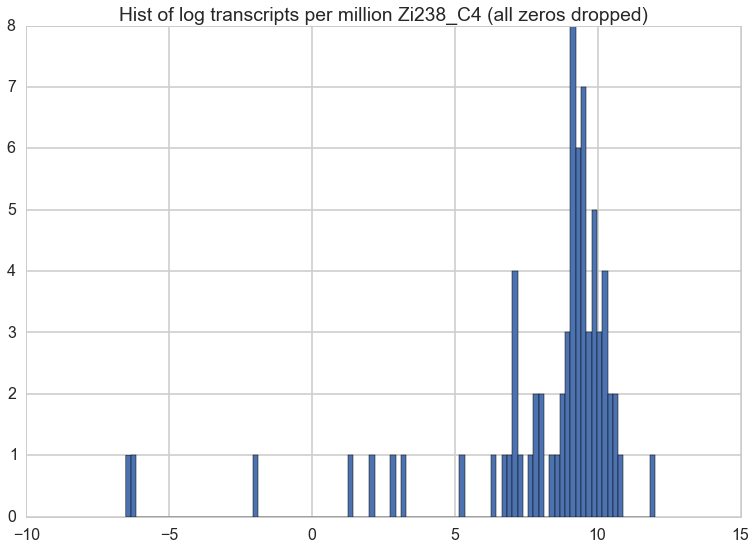

In [9]:
Zi238_C4 =pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/Zi238_C4_AGTTCC/abundance.tsv",sep="\t")
print "Zi238_C4", Zi238_C4.describe()
print

Fr188_T3=pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/Fr188_T3_GTCCGC/abundance.tsv",sep="\t")
print "Fr188_T3", Fr188_T3.describe()

plt.hist(np.log(Fr188_T3[Fr188_T3.tpm>0].tpm).values, bins=100)
plt.title("Hist of log transcripts per million Fr188_T3 (all zeros dropped)")
plt.show()

plt.hist(np.log(Zi238_C4[Zi238_C4.tpm>0].tpm).values, bins=100)
plt.title("Hist of log transcripts per million Zi238_C4 (all zeros dropped)")
plt.show()

In [10]:
#Deleting initial weird outliers (these showed up in PCA as outliers).  
del LoadedData["Zi238_C4"]
del LoadedData["Fr188_T3"] 

In [11]:
LoadedData.head()

,Fr188_C1,Fr188_C2,Fr188_C3,Fr188_T5,Fr188_T6,Fr89_C1,Fr89_C2,Fr89_C4,Fr89_T3,Fr89_T4,Fr89_T5,Zi238_C1,Zi238_C2,Zi238_C3,Zi238_T2,Zi238_T3,Zi238_T4,Zi257_C1,Zi257_C2,Zi257_C3,Zi257_T1,Zi257_T2,Zi257_T3,Zi257_T4
0,0.504464,1.284890,0.614044,0.000000,0.000000,0.440369,0.691164,0.262204,0.000000,0.147861,0.00000,0.440267,0.652083,0.894199,1.548400e-01,0.000000,0.133242,0.00000,0.57178,0.37936,0.000000,0.105309,0.00000,0.00000
1,2.973920,4.151500,5.322480,5.352650,3.635080,10.496100,8.771190,1.165150,4.027210,3.819260,5.20589,4.586930,5.192110,1.115020,4.127860e+00,3.603360,4.166850,5.08526,8.40361,6.08674,5.779740,4.997630,3.46231,5.69248
2,2.265180,1.434560,0.000000,0.000000,0.461069,1.724620,0.563522,5.122970,0.000000,0.000000,0.00000,2.278640,1.485840,5.823160,0.000000e+00,0.000000,0.351757,5.27287,0.00000,4.23550,0.413694,0.000000,0.32999,0.00000
3,0.741191,0.350953,0.000484,0.445147,0.000000,0.923483,0.000000,1.166280,0.158618,0.428323,0.00000,0.429408,0.000000,0.000000,1.491710e-07,0.411839,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000
4,2.052320,0.690347,1.806490,4.507330,4.265000,2.172480,0.869259,1.108070,3.678080,3.580640,3.87075,2.379780,2.346690,3.902570,4.123990e+00,5.012800,4.700970,1.88296,2.12189,2.37721,4.582620,3.783650,4.41964,2.67030


<a id='Preliminary PCA non logged'></a>
###Do a PCA (non logged data)

In [12]:
pca = PCA(n_components=50)
X = pca.fit_transform(LoadedData.transpose())
pca.explained_variance_ratio_.sum()

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


0.99999999999999989

In [13]:
pca.explained_variance_ratio_*100

array([  9.55598436e+01,   1.39003128e+00,   1.22922896e+00,
         5.98588225e-01,   4.14025073e-01,   2.64173386e-01,
         1.25635313e-01,   1.03706528e-01,   9.26307061e-02,
         4.95548686e-02,   3.14791172e-02,   2.70593735e-02,
         2.26876882e-02,   1.79350275e-02,   1.62479180e-02,
         1.34034501e-02,   1.06414635e-02,   8.61505971e-03,
         7.49915296e-03,   5.87843840e-03,   4.59324222e-03,
         3.60015266e-03,   2.94200828e-03,   1.20493508e-29])

The variance is really explained here by the first two components

In [14]:
#Applying labels to dataframe
dfPCA=applyLabels(LoadedData, pca)

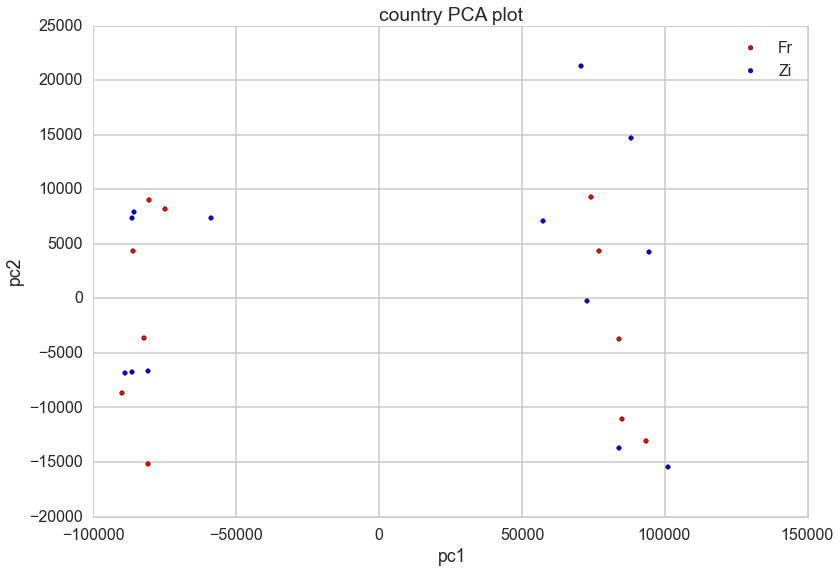

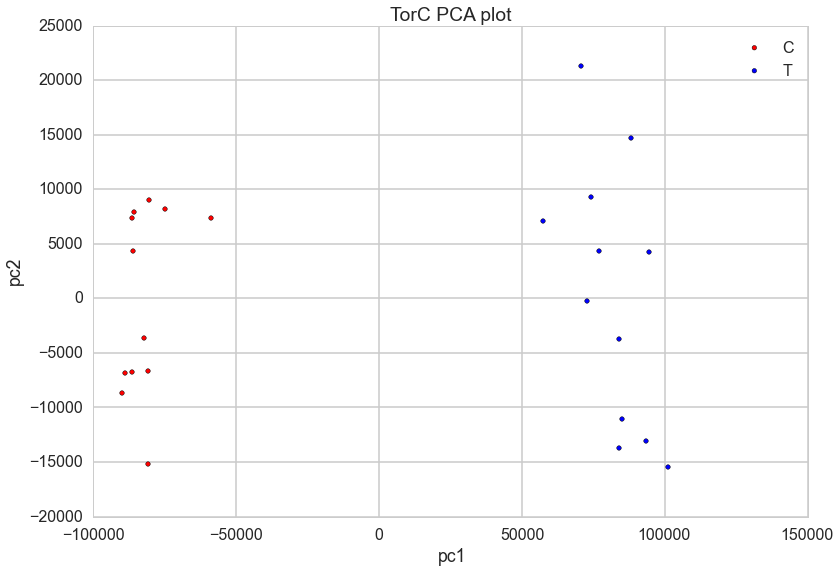

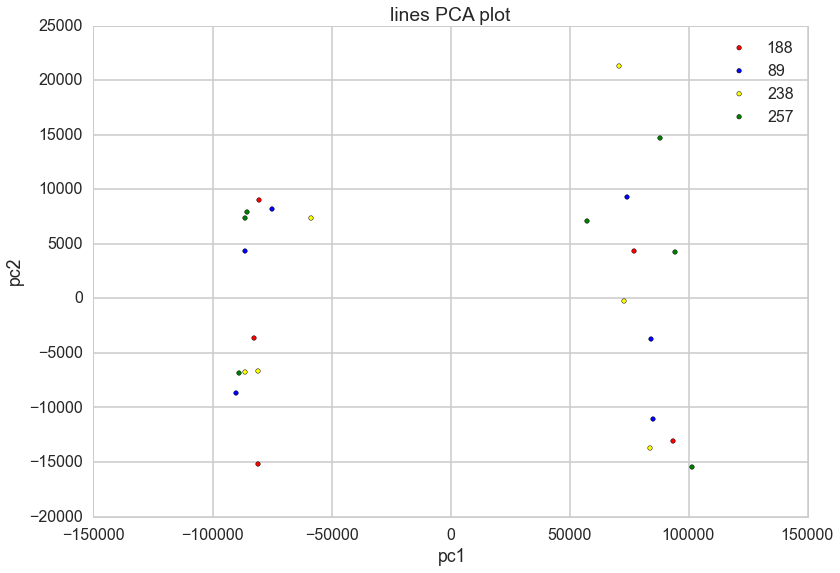

In [15]:
plot_PCA("country",dfPCA)
plot_PCA("TorC", dfPCA)
plot_PCA("lines",dfPCA)

Carcass points cluster together.  Lines do not cluster together, nor do countries.  No clear outliers.

<a id='Preliminary PCA logged'></a>
##Taking log of the data

We replace all 0 values by 1/1million.  We also try various cutoffs.

In [62]:
cutoff=0.01
LoadedDataLog=LoadedData.replace(0, 1e-06)
mask= LoadedDataLog.apply(lambda x : (x > cutoff))
LoadedDataLog=LoadedDataLog[mask.all(axis=1)]


LoadedDataLog=LoadedDataLog.apply(np.log)

pca = PCA(n_components=50)
X = pca.fit_transform(LoadedDataLog.transpose())
pca.explained_variance_ratio_.sum()

0.99999999999999989

In [63]:
pca.explained_variance_ratio_*100

array([  8.80595802e+01,   2.15611052e+00,   1.40019149e+00,
         8.09363908e-01,   7.01747588e-01,   6.51813413e-01,
         5.60254624e-01,   5.29316600e-01,   5.01027258e-01,
         4.86847202e-01,   4.44664136e-01,   4.19557849e-01,
         3.98819879e-01,   3.91545949e-01,   3.64055403e-01,
         3.36624521e-01,   2.92967871e-01,   2.89322310e-01,
         2.67620007e-01,   2.63015331e-01,   2.40616359e-01,
         2.38315869e-01,   1.96621664e-01,   1.64392439e-29])

In [64]:
#Applying labels to dataframe
dfPCA=applyLabels(LoadedDataLog, pca)

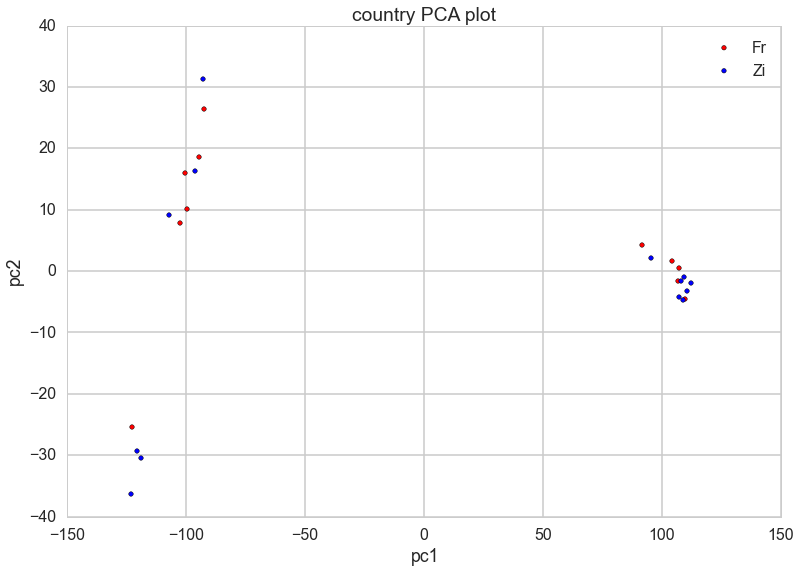

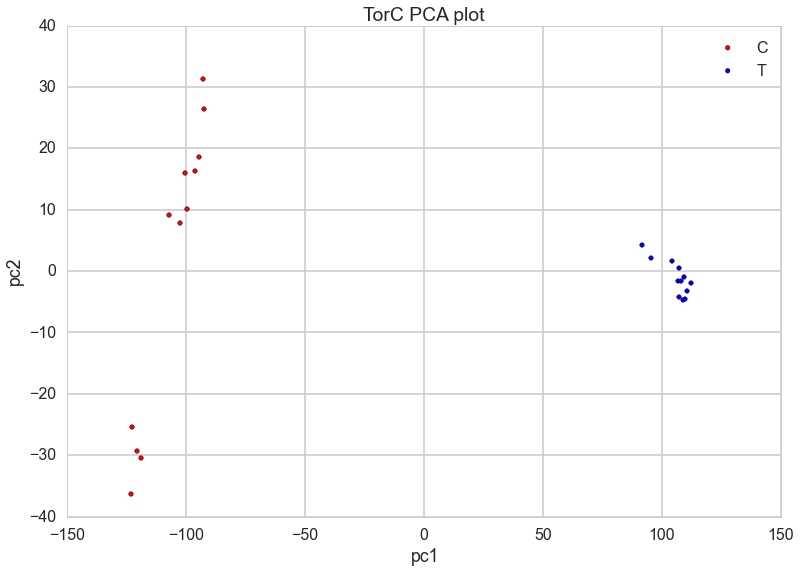

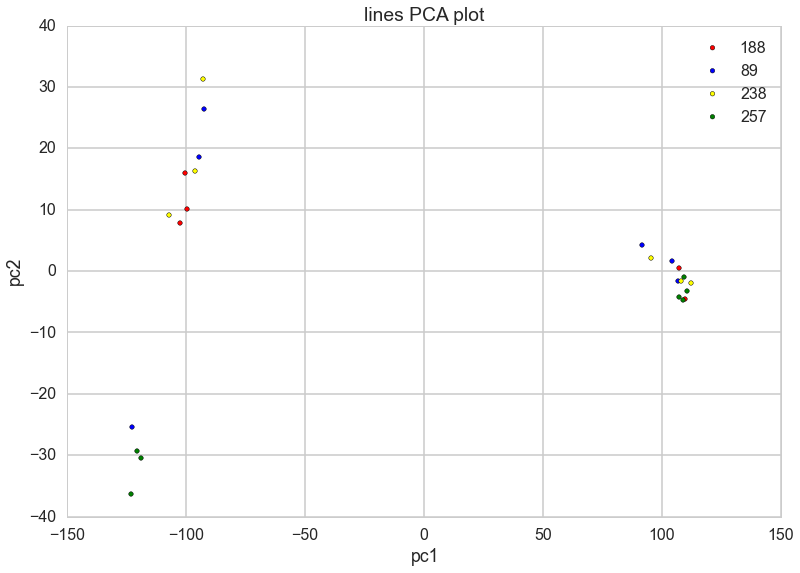

In [65]:
plot_PCA("country",dfPCA)
plot_PCA("TorC", dfPCA)
plot_PCA("lines",dfPCA)

Plotting PC2 vs PC3 -- can't see much clustering there either.

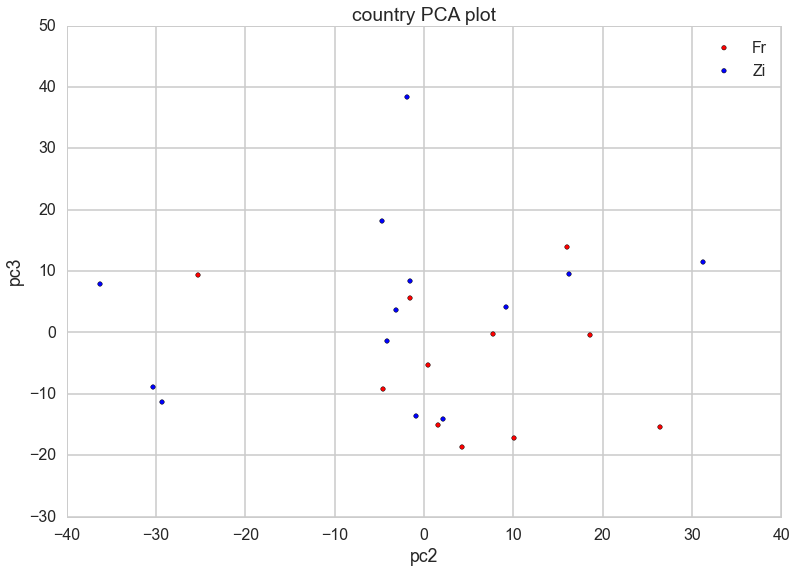

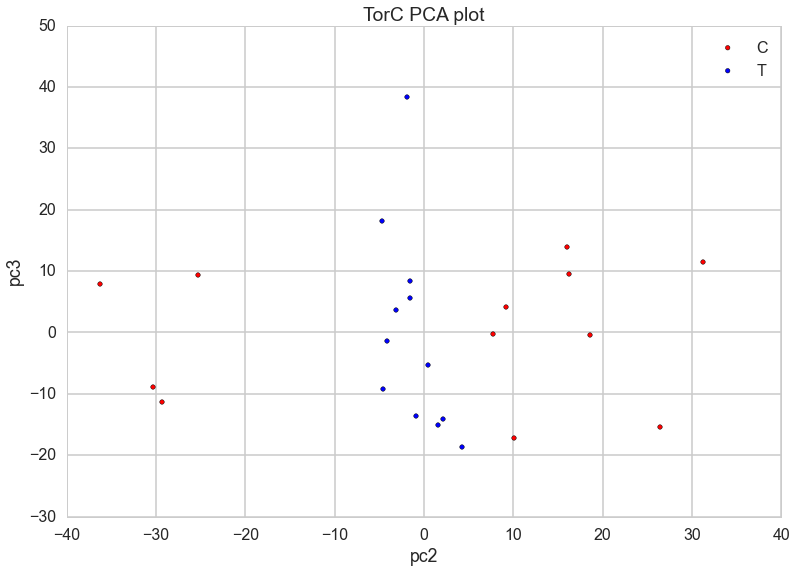

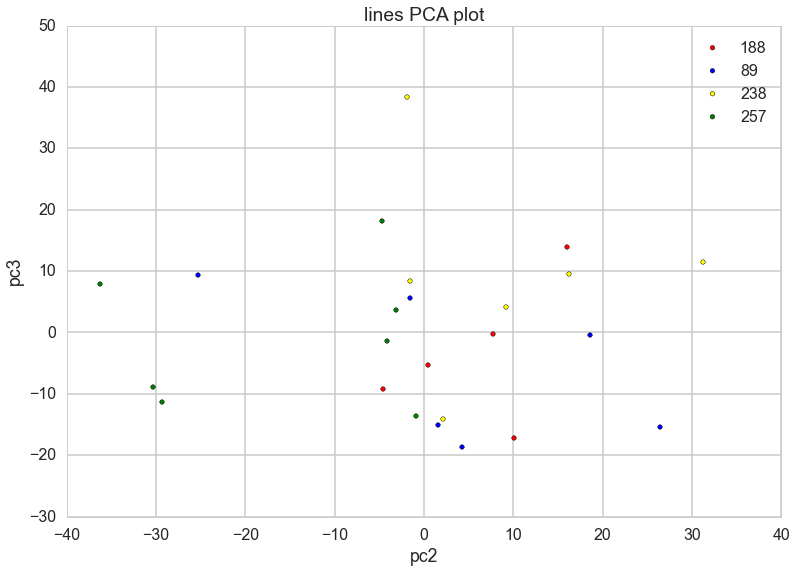

In [66]:
plot_PCA("country",dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("TorC", dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("lines",dfPCA, firstComponent="pc2", secondComponent="pc3")

<a id='Carcass only data'></a>

#Carcass only data

In [71]:
#Create carcass dataframe on logged dataframe
TorClabels=[a.split('_')[1][0] for a in LoadedDataLog.columns]
dfCarcass=LoadedDataLog[[col for lab,col in zip(TorClabels,LoadedDataLog.columns) if lab=="C"]]
pca = PCA(n_components=20)
X = pca.fit_transform(dfCarcass.transpose())
pca.explained_variance_ratio_*100

array([  3.75211130e+01,   1.26577711e+01,   9.58339641e+00,
         7.54128701e+00,   6.64335172e+00,   5.92654647e+00,
         5.31762047e+00,   4.25228543e+00,   3.99181085e+00,
         3.69627910e+00,   2.86853844e+00,   1.66559206e-28])

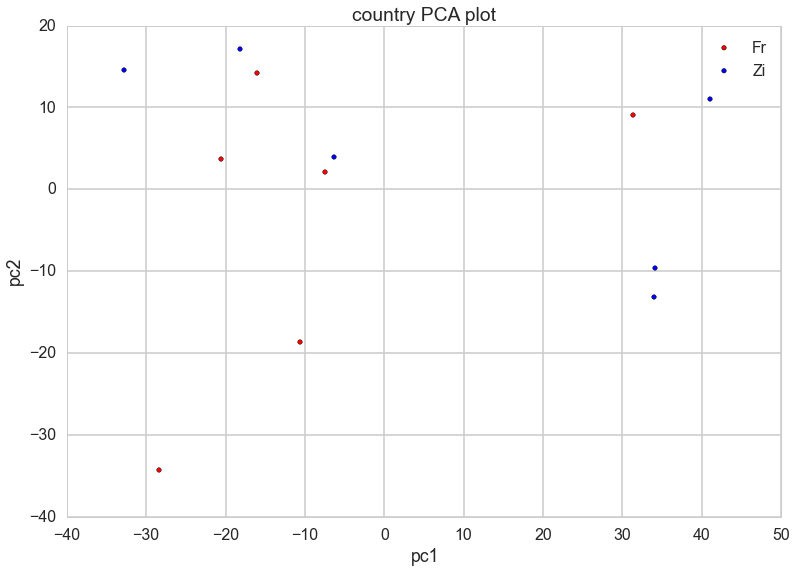

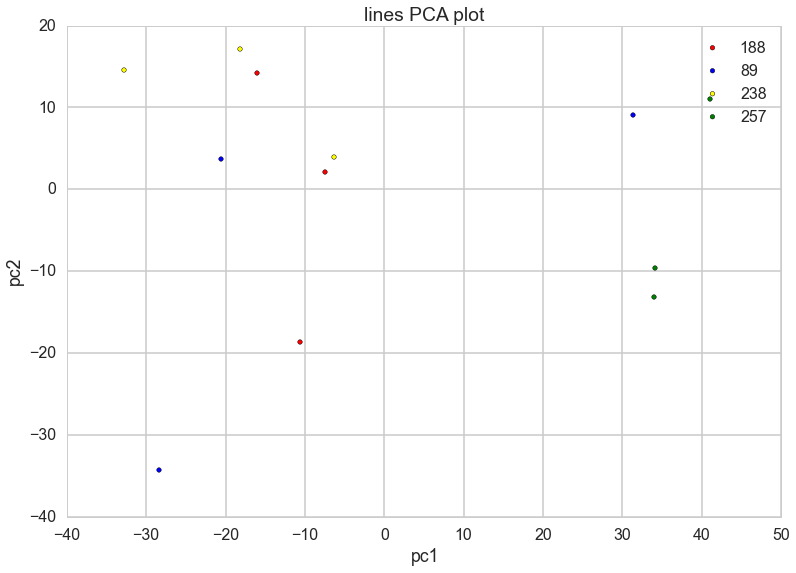

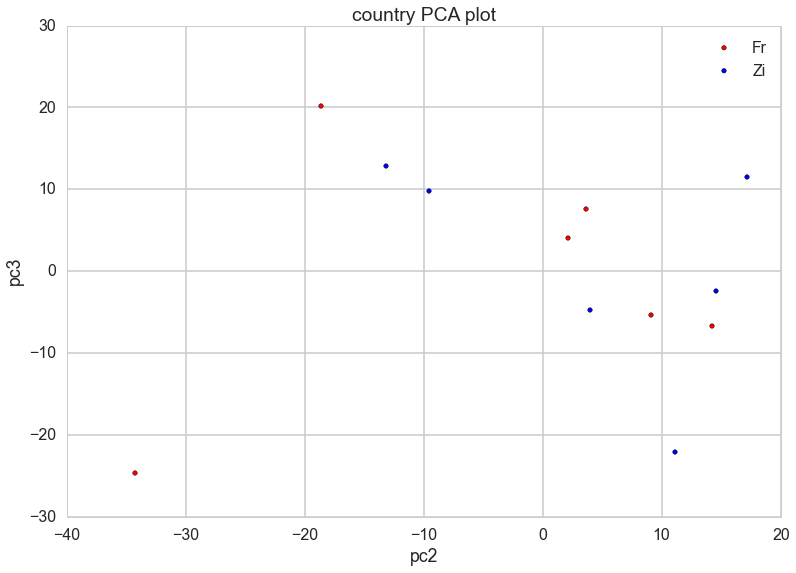

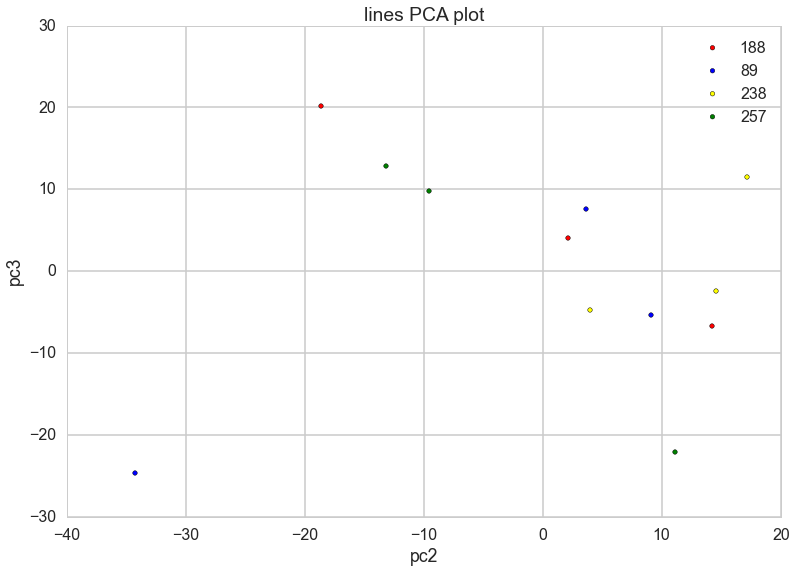

In [72]:
dfPCA=applyLabels(dfCarcass, pca, TorC=False)
plot_PCA("country",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("lines",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("country",dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("lines",dfPCA, firstComponent="pc2", secondComponent="pc3")

<a id='Testes only data'></a>

#Testes only data

In [69]:
#Create carcass dataframe on logged dataframe
TorClabels=[a.split('_')[1][0] for a in LoadedDataLog.columns]
dfTestes=LoadedDataLog[[col for lab,col in zip(TorClabels,LoadedDataLog.columns) if lab=="T"]]
pca = PCA(n_components=20)
X = pca.fit_transform(dfTestes.transpose())
pca.explained_variance_ratio_*100

array([  2.21458694e+01,   1.25995591e+01,   1.10346206e+01,
         9.86273166e+00,   8.68062246e+00,   7.87675044e+00,
         7.08251126e+00,   6.43945948e+00,   5.13564727e+00,
         4.68043221e+00,   4.46179612e+00,   1.35595503e-28])

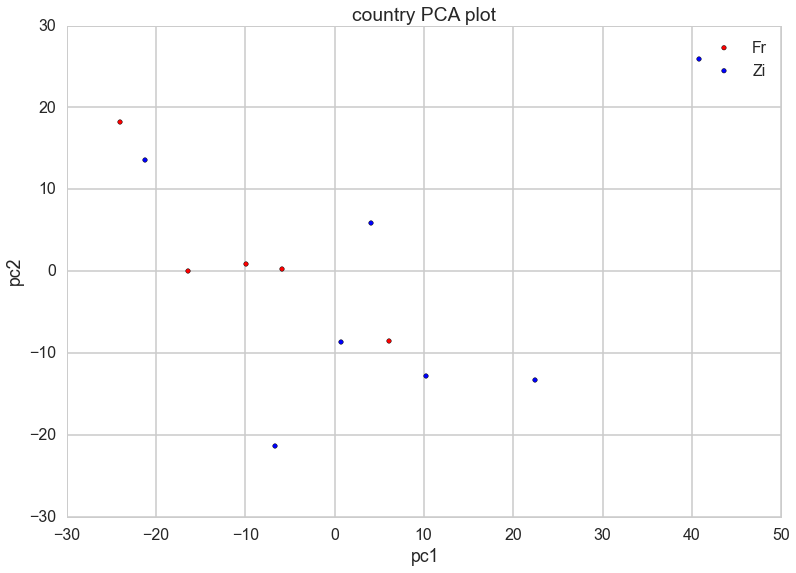

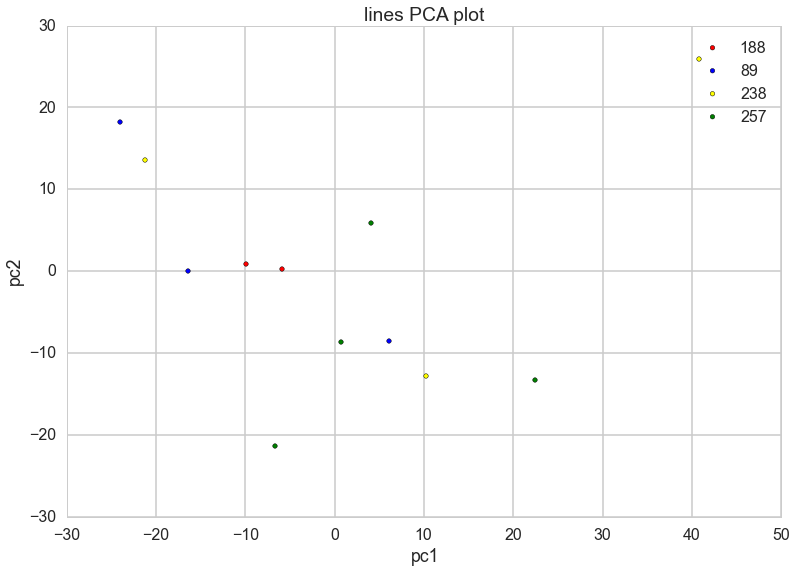

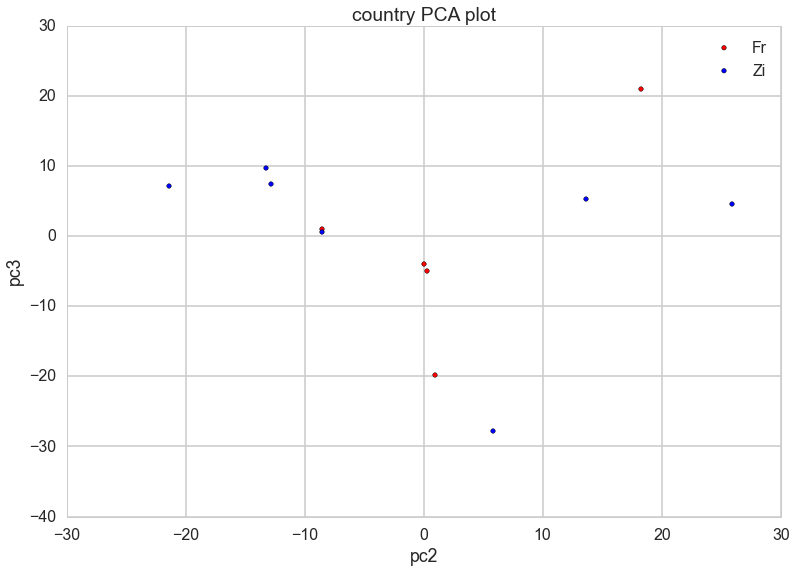

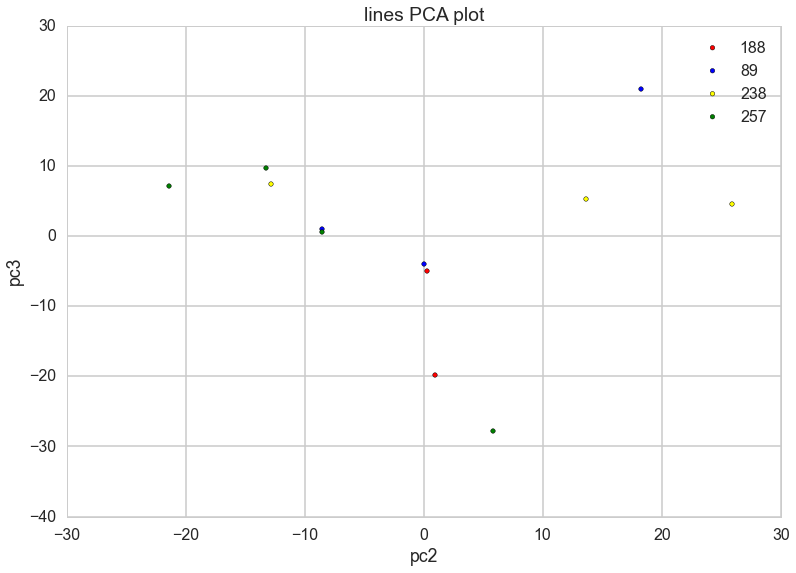

In [70]:
dfPCA=applyLabels(dfTestes, pca, TorC=False)
plot_PCA("country",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("lines",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("country",dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("lines",dfPCA, firstComponent="pc2", secondComponent="pc3")